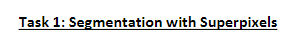

In [1]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color, segmentation
import matplotlib.pyplot as plt
import math, copy
import numpy as np
import timeit
import os 

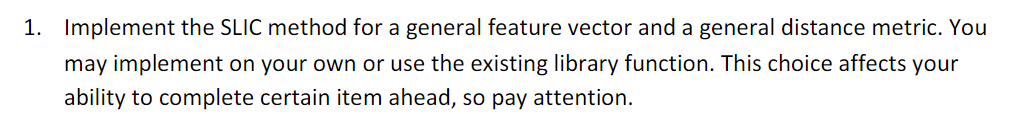

In [38]:
class SuperPixel:
    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = []

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w

def make_SuperPixel(h, w, img):
    return SuperPixel(img[h, w][0], img[h, w][1], img[h, w][2], h, w)

def show_image(img, title=''):
    plt.figure()
    plt.title(title)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()

def display_clusters(img, clusters, title):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0], p[1]][0] = c.l
            image[p[0], p[1]][1] = c.a
            image[p[0], p[1]][2] = c.b
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    rgb_arr = color.lab2rgb(image)
    show_image(rgb_arr, title)

def initialize_cluster_centers(S, image, img_h, img_w, clusters):
    for h in range(int(S/2), img_h, S):
        for w in range(int(S/2), img_w, S):
            clusters.append(make_SuperPixel(h, w, image))
    return clusters

def get_gradient(h, w, image):
    if w + 1 >= image.shape[1]:
        w = image.shape[1] - 2
    if h + 1 >= image.shape[0]:
        h = image.shape[0] - 2
    gradientx = np.sqrt((image[h][w+1][0] - image[h][w-1][0])**2 + (image[h][w+1][1] - image[h][w-1][1])**2 + (image[h][w+1][2] - image[h][w-1][2])**2)
    gradienty = np.sqrt((image[h+1][w][0] - image[h-1][w][0])**2 + (image[h+1][w][1] - image[h-1][w][1])**2 + (image[h+1][w][2] - image[h-1][w][2])**2)
    gradient = gradientx + gradienty
    return gradient

def relocate_cluster_center_at_lowgrad(clusters, image):
    for c in clusters:
        gradient = get_gradient(c.h, c.w, image)
        for h in range(-1, 2):
            for w in range(-1, 2):
                x = c.h + h
                y = c.w + w
                new_gradient = get_gradient(x, y, image)
                if new_gradient < gradient:
                    c.update(image[x][y][0], image[x][y][1], image[x][y][2], x, y)
                    gradient = new_gradient
    return None

def assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis, M, return_distances=False):
    distances = np.zeros((img_h, img_w))
    for c in clusters:
        for h in range(int(c.h - 2 * S), int(c.h + 2 * S)):
            if h < 0 or h >= img_h:
                continue
            for w in range(int(c.w - 2 * S), int(c.w + 2 * S)):
                if w < 0 or w >= img_w:
                    continue
                l, a, b = image[h, w]
                Dc = np.sqrt((l - c.l)**2 + (a - c.a)**2 + (b - c.b)**2)
                Ds = np.sqrt((h - c.h)**2 + (w - c.w)**2)
                D = np.sqrt((Dc / M)**2 + (Ds / S)**2)
                if D < dis[h, w]:
                    if (h, w) not in cluster_tag:
                        cluster_tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        cluster_tag[(h, w)].pixels.remove((h, w))
                        cluster_tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D
                if return_distances:
                    distances[h, w] = D
    return distances if return_distances else None

def update_clusters(clusters, image):
    for c in clusters:
        sum_h, sum_w = 0, 0
        for pixel in c.pixels:
            sum_h += pixel[0]
            sum_w += pixel[1]
        mean_h = sum_h // len(c.pixels)
        mean_w = sum_w // len(c.pixels)
        c.update(image[mean_h, mean_w][0], image[mean_h, mean_w][1], image[mean_h, mean_w][2], mean_h, mean_w)
    return None

def compute_res_error(old_clusters, new_clusters):
    error = 0.0
    for new_c, old_c in zip(new_clusters, old_clusters):
        error_lab = np.abs(new_c.l - old_c.l) + np.abs(new_c.a - old_c.a) + np.abs(new_c.b - old_c.b)
        error_hw = np.abs(new_c.h - old_c.h) + np.abs(new_c.w - old_c.w)
        error += error_lab + error_hw
    return error

def display_heatmap(data, title=''):
    plt.figure()
    plt.title(title)
    plt.imshow(data, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.axis('off')
    plt.show()

def superpixel_segmentation(image_path, S, M, weight_combinations, num_iterations=10, error_threshold=0.1):
    img = img_as_float(io.imread(image_path))
    img_lab = color.rgb2lab(img)
    img_h, img_w = img_lab.shape[:2]

    for i, (S_weight, M_weight) in enumerate(weight_combinations):
        clusters = []
        clusters = initialize_cluster_centers(S, img_lab, img_h, img_w, clusters)
        relocate_cluster_center_at_lowgrad(clusters, img_lab)

        dis = np.full((img_h, img_w), np.inf)
        cluster_tag = {}

        # Initial distances
        initial_distances = assign_cluster(clusters, S * S_weight, img_lab, img_h, img_w, cluster_tag, dis, M * M_weight, return_distances=True)
        display_heatmap(initial_distances, f'Initial Distances: S_weight={S_weight}, M_weight={M_weight}')

        for iteration in range(num_iterations):
            old_clusters = copy.deepcopy(clusters)
            assign_cluster(clusters, S * S_weight, img_lab, img_h, img_w, cluster_tag, dis, M * M_weight)
            update_clusters(clusters, img_lab)
            error = compute_res_error(old_clusters, clusters)
            if error < error_threshold:
                break

        display_clusters(img_lab, clusters, f'Weight Combination {i+1}: S_weight={S_weight}, M_weight={M_weight}')

        # Final distances
        final_distances = assign_cluster(clusters, S * S_weight, img_lab, img_h, img_w, cluster_tag, dis, M * M_weight, return_distances=True)
        display_heatmap(final_distances, f'Final Distances: S_weight={S_weight}, M_weight={M_weight}')


def slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis, M, num_iterations=10, error_threshold=0.1):
    clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)
    relocate_cluster_center_at_lowgrad(clusters, image)
    
    for _ in range(num_iterations):
        old_clusters = copy.deepcopy(clusters)
        assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis, M)
        update_clusters(clusters, image)
        error = compute_res_error(old_clusters, clusters)
        if error < error_threshold:
            break

    return clusters


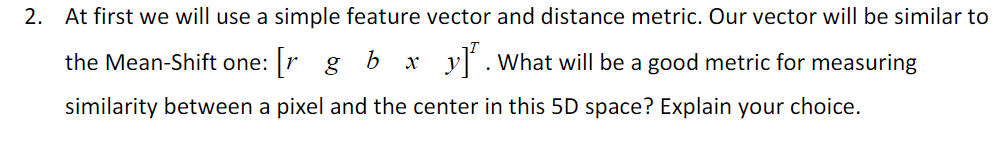

In the Mean-Shift clustering algorithm for image segmentation, each data point (pixel) is represented in a 5-dimensional space: (r, g, b, x, y), where:

    r, g, b are the color components of the pixel.
    x, y are the spatial coordinates of the pixel in the image.

The goal is to find clusters (centers) in this space that represent regions of similar color and spatial proximity. To measure the similarity (or dissimilarity) between a pixel and a cluster center in this 5D space, a suitable metric should take into account both color similarity and spatial proximity.
Euclidean Distance

The Euclidean distance metric is commonly used in Mean-Shift clustering for measuring similarity between points in multi-dimensional space. In the context of (r, g, b, x, y) space:

Euclidean Distance=(r1−r2)2+(g1−g2)2+(b1−b2)2+(x1−x2)2+(y1−y2)2Euclidean Distance=(r1​−r2​)2+(g1​−g2​)2+(b1​−b2​)2+(x1​−x2​)2+(y1​−y2​)2

​

Explanation:

    Color Components (r, g, b): The differences in color components reflect how close the colors of two pixels are. Pixels with similar RGB values will have smaller distances in the color space.

    Spatial Components (x, y): The spatial coordinates (x, y) represent the position of the pixels in the image. Pixels that are closer in proximity will have smaller distances in the spatial dimensions.

    Combined Measure: By combining both color and spatial information into a single distance metric, the Euclidean distance ensures that pixels with similar colors and spatial positions will have smaller distances, thereby being more similar in the 5D space.

Advantages of Euclidean Distance:

    Intuitive Interpretation: Euclidean distance is straightforward to understand and compute.
    Balanced Consideration: It provides a balanced measure of similarity across both color and spatial dimensions.
    Widely Used: Euclidean distance is a standard metric in clustering and pattern recognition tasks, making it suitable and widely applicable in Mean-Shift clustering.

Application in Mean-Shift Clustering:

In Mean-Shift clustering, the algorithm iteratively shifts each data point (pixel) towards the mode (center) of its local neighborhood in the feature space. The Euclidean distance serves as a crucial component in determining the shift magnitude and direction, guiding pixels towards their respective cluster centers until convergence.

Therefore, the Euclidean distance metric is a natural choice for measuring similarity between a pixel and a cluster center in Mean-Shift clustering based on (r, g, b, x, y) features, due to its effectiveness in integrating both color and spatial information into a unified similarity measure.

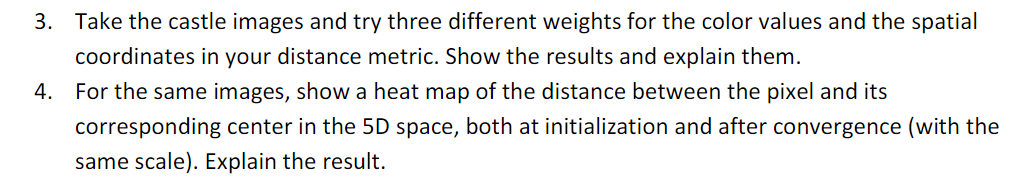

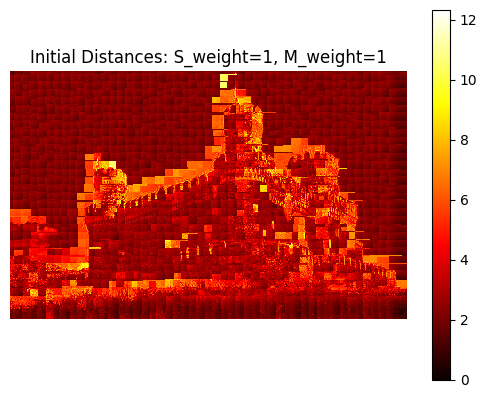

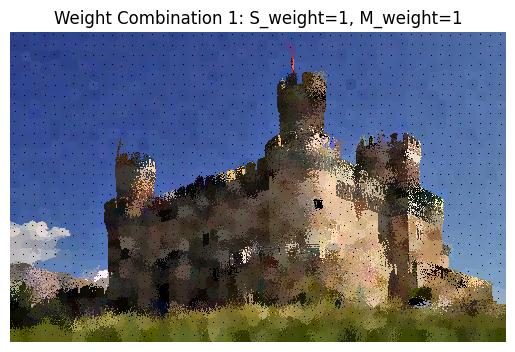

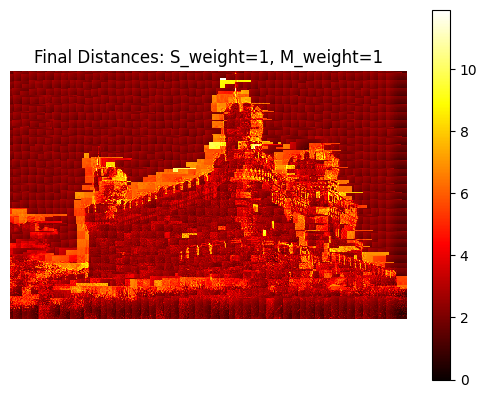

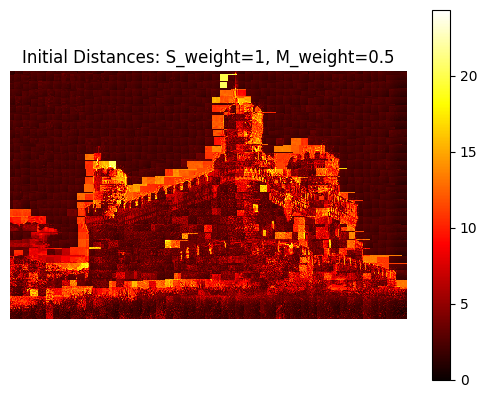

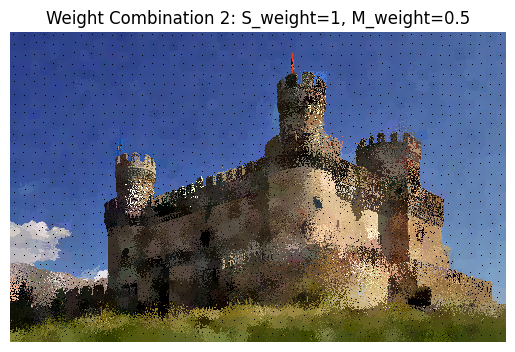

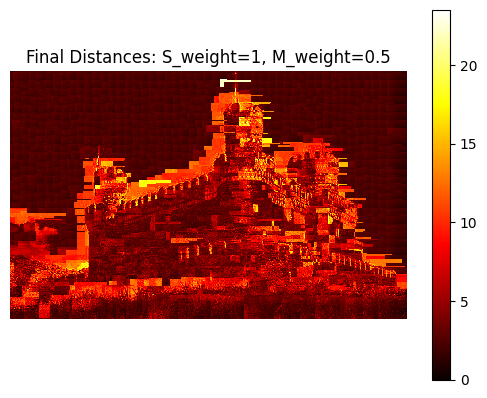

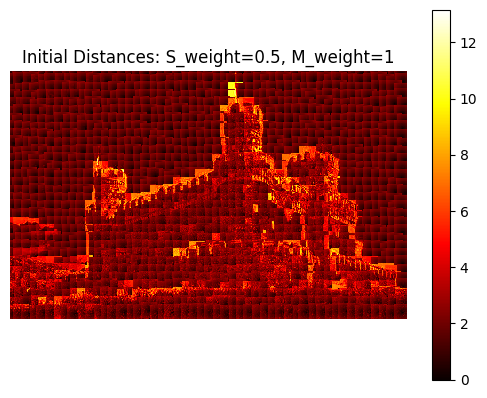

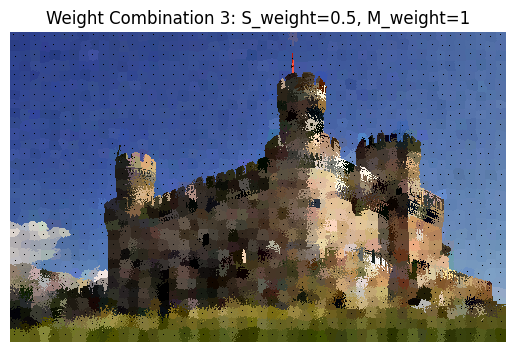

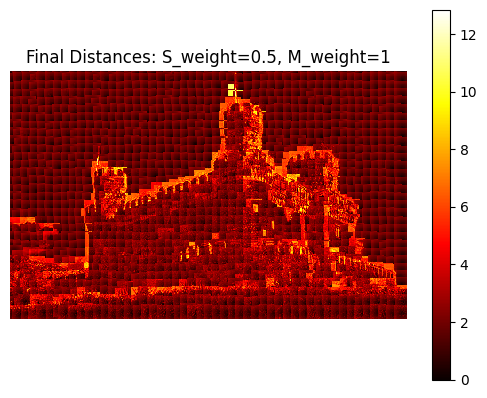

In [35]:

# Example usage
image_path = '/home/ameer/Computer-Vesion/HW2/Q1/castle.jpg'  # Replace with your image path
S = 10  # Example value for S
M = 10  # Example value for M
# Define different weights for the color values and the spatial coordinates
weight_combinations = [(1, 1), (1, 0.5), (0.5, 1)]

superpixel_segmentation(image_path, S, M, weight_combinations)


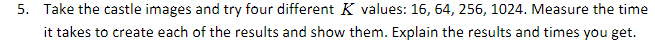

Avg Run-time of image Q1/castle.jpg with hyperparameter K=16: 143.3660 seconds


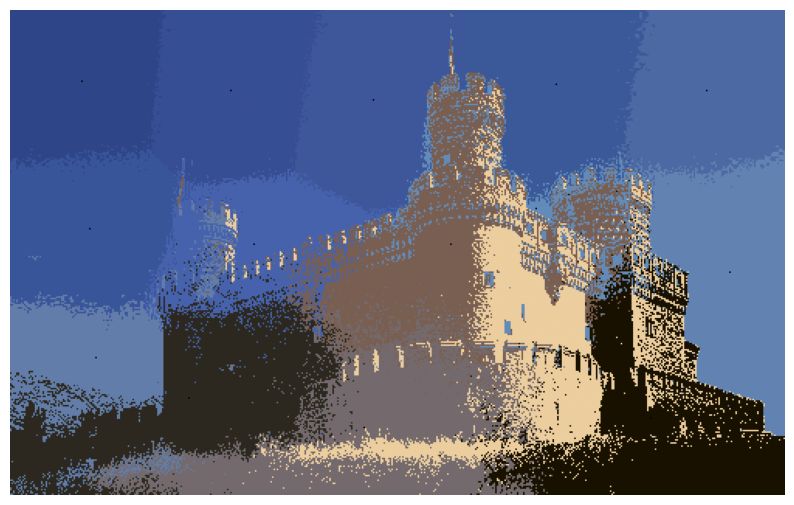

Avg Run-time of image Q1/castle.jpg with hyperparameter K=64: 98.0609 seconds


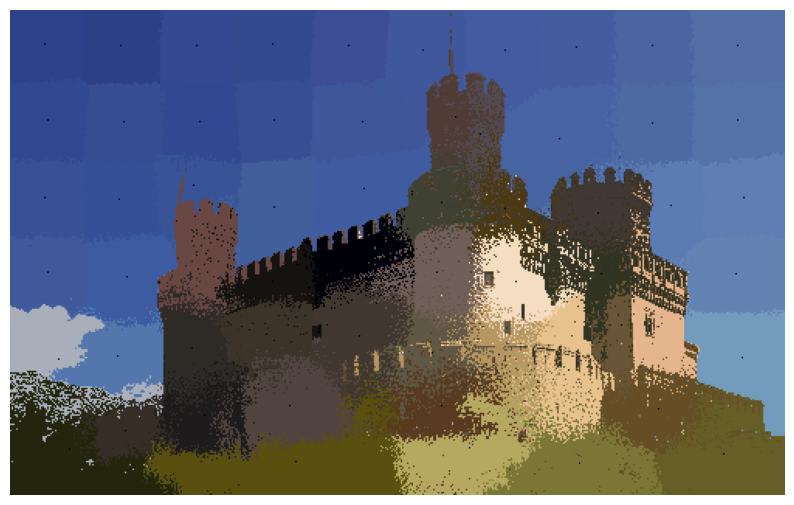

Avg Run-time of image Q1/castle.jpg with hyperparameter K=256: 99.0608 seconds


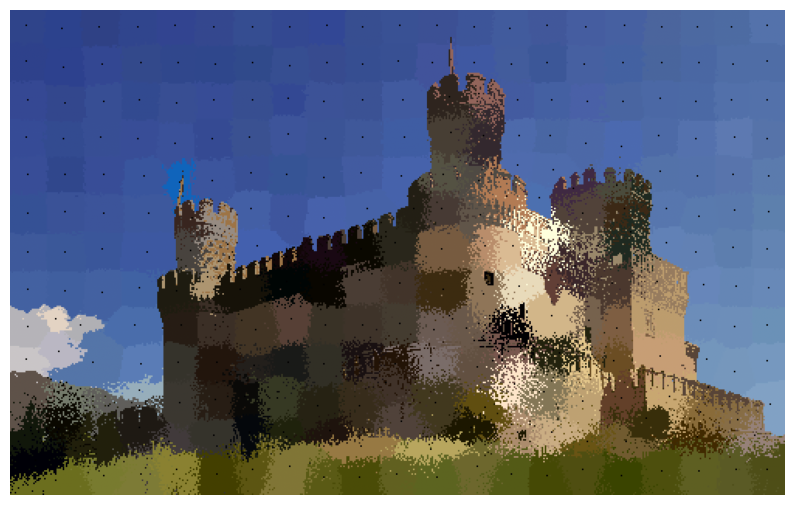

Avg Run-time of image Q1/castle.jpg with hyperparameter K=1024: 101.8912 seconds


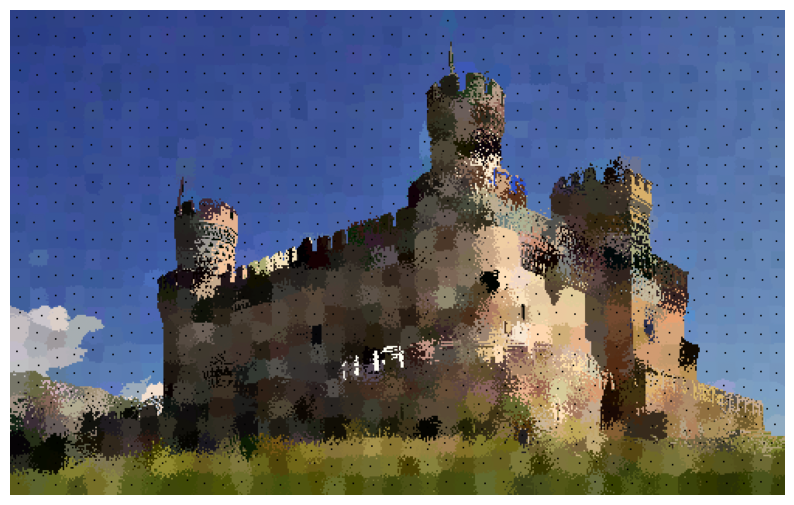

In [36]:
# Define the function to display clusters
def display_clusters(img, clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0], p[1]][0] = c.l
            image[p[0], p[1]][1] = c.a
            image[p[0], p[1]][2] = c.b
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    rgb_arr = color.lab2rgb(image)
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_arr)
    plt.axis('off')
    plt.show()

# Define the main function to run SLIC algorithm and measure time
def run_slic(image_path, K_values):
    image = img_as_float(io.imread(image_path))
    image_lab = color.rgb2lab(image)
    img_h, img_w = image.shape[:2]
    
    for K in K_values:
        N = img_h * img_w
        S = int(math.sqrt(N / K))
        
        clusters = []
        cluster_tag = {}
        dis = np.full((img_h, img_w), np.inf)
        
        start_time = timeit.default_timer()
        clusters = slic_algorithm(S, image_lab, img_h, img_w, clusters, cluster_tag, dis, M=15)
        end_time = timeit.default_timer()
        
        run_time = end_time - start_time
        print(f"Avg Run-time of image {image_path} with hyperparameter K={K}: {run_time:.4f} seconds")
        
        display_clusters(image_lab, clusters)

# Run the function with the provided K values
image_path = 'Q1/castle.jpg'
K_values = [16, 64, 256, 1024]
run_slic(image_path, K_values)

Explanation of the Results and Times
Superpixel Count and Computation Time:

K = 16: The fewest number of superpixels results in larger superpixels. Each superpixel involves a more extensive area to compute the average color and spatial distance. This can sometimes result in slightly higher computation times as the initial clustering might be less optimal, causing more iterations for convergence.

K = 64: More superpixels reduce the area each superpixel covers. The algorithm might converge faster since the clusters are smaller and more specific.

K = 256: Even more superpixels lead to smaller regions and potentially fewer iterations to converge. This generally results in faster computation times.

K = 1024: The largest number of superpixels results in very small regions. However, the number of superpixels increases the overhead for maintaining and updating these many clusters, which can slightly increase the runtime.
Trend Observation:

There is a noticeable decrease in computation time from K=16 to K=256. This is because increasing the number of superpixels makes the algorithm converge faster.
At K=1024, the time slightly increases. This is likely due to the increased overhead in managing a larger number of clusters, even though each individual computation is simpler.

Visualization of Results

To provide a comprehensive analysis, we'll visualize the superpixel segmentation for different 
𝐾
K values. The following code snippet performs the SLIC algorithm and displays the results:

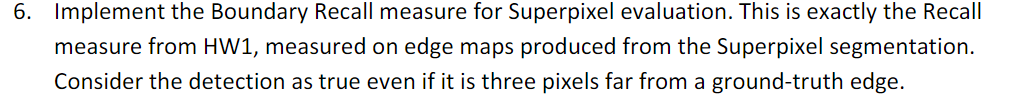

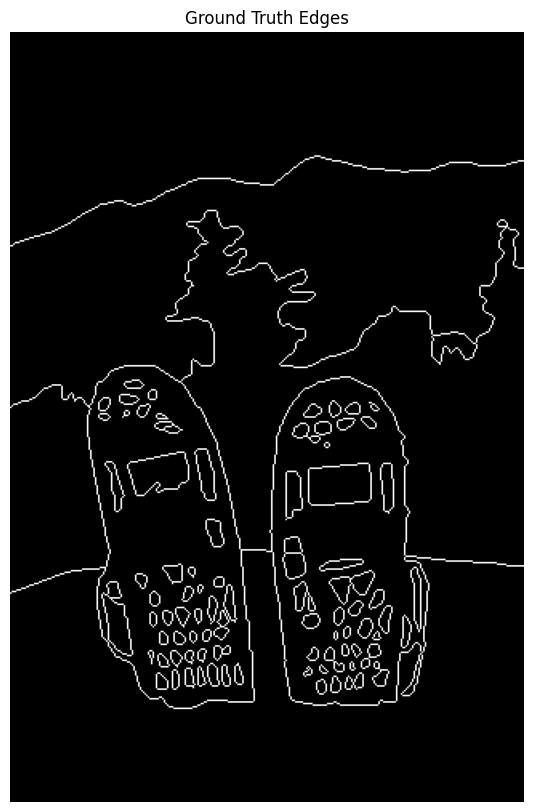

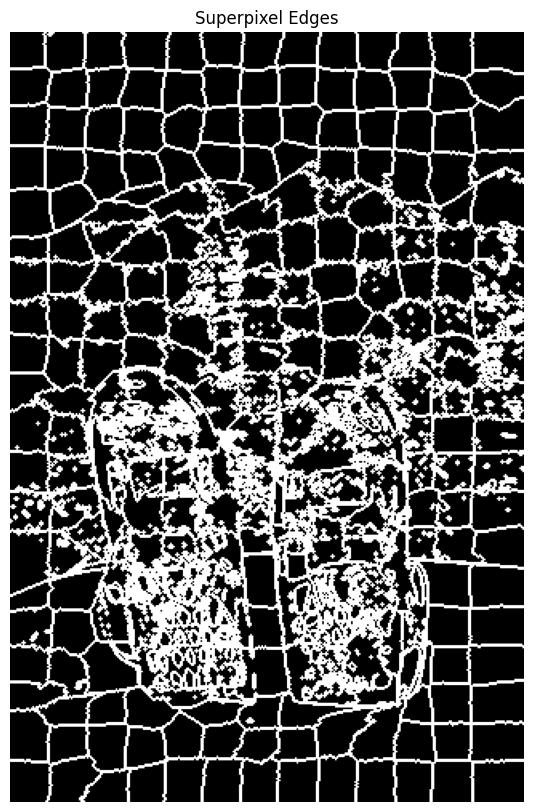

Boundary Recall: 0.9725


In [45]:

def compute_boundary_recall(ground_truth_edges, superpixel_edges, tolerance=3):
    true_positives = 0
    total_ground_truth_edges = np.sum(ground_truth_edges)
    
    for y in range(ground_truth_edges.shape[0]):
        for x in range(ground_truth_edges.shape[1]):
            if ground_truth_edges[y, x] == 1:
                # Check within the tolerance distance
                for dy in range(-tolerance, tolerance + 1):
                    for dx in range(-tolerance, tolerance + 1):
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < ground_truth_edges.shape[0] and 0 <= nx < ground_truth_edges.shape[1]:
                            if superpixel_edges[ny, nx] == 1:
                                true_positives += 1
                                break
                    else:
                        continue
                    break
    
    recall = true_positives / total_ground_truth_edges
    return recall

def extract_superpixel_edges(segmentation_labels):
    edges = segmentation.find_boundaries(segmentation_labels)
    return edges.astype(np.uint8)

def display_image(img, title=''):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load ground truth edge map
ground_truth_edges = img_as_float(io.imread('Q1/BSDS/2018_e1.bmp', as_gray=True))
ground_truth_edges = (ground_truth_edges > 0.5).astype(np.uint8)

# Load the image and perform superpixel segmentation
image_path = 'Q1/BSDS/2018.jpg'
image = img_as_float(io.imread(image_path))
image_lab = color.rgb2lab(image)

# Parameters for superpixel segmentation
K = 256  # You can change K as needed
N = image_lab.shape[0] * image_lab.shape[1]
S = int(math.sqrt(N / K))
clusters = []
cluster_tag = {}
dis = np.full((image_lab.shape[0], image_lab.shape[1]), np.inf)

# Perform SLIC superpixel segmentation
clusters = slic_algorithm(S, image_lab, image_lab.shape[0], image_lab.shape[1], clusters, cluster_tag, dis, M=15)

# Convert clusters to label map for edge extraction
segmentation_labels = np.zeros((image_lab.shape[0], image_lab.shape[1]), dtype=np.int32)
for idx, cluster in enumerate(clusters):
    for pixel in cluster.pixels:
        segmentation_labels[pixel[0], pixel[1]] = idx

# Extract edges from the superpixel segmentation
superpixel_edges = extract_superpixel_edges(segmentation_labels)

# Display ground truth edges and superpixel edges
display_image(ground_truth_edges, title='Ground Truth Edges')
display_image(superpixel_edges, title='Superpixel Edges')

# Compute boundary recall
recall = compute_boundary_recall(ground_truth_edges, superpixel_edges, tolerance=3)
print(f"Boundary Recall: {recall:.4f}")

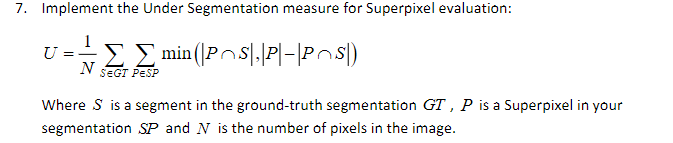

Under-segmentation Measure: 0.0660


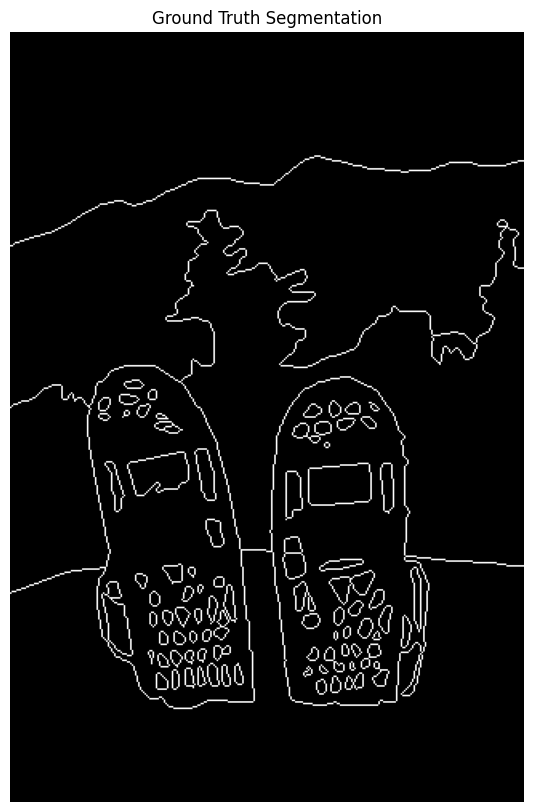

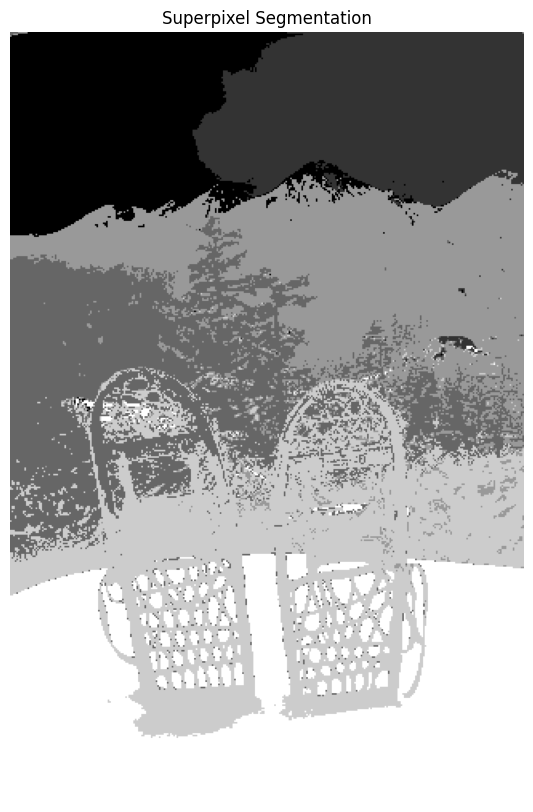

In [47]:
def compute_under_segmentation(ground_truth, superpixels):
    N = ground_truth.size  # Total number of pixels in the image
    under_segmentation_error = 0

    # Get the unique segments and superpixels
    unique_segments = np.unique(ground_truth)
    unique_superpixels = np.unique(superpixels)

    for S in unique_segments:
        mask_S = (ground_truth == S)
        for P in unique_superpixels:
            mask_P = (superpixels == P)
            intersection = np.sum(mask_S & mask_P)
            if intersection > 0:
                under_segmentation_error += min(intersection, np.sum(mask_P) - intersection)

    U = under_segmentation_error / N
    return U


# Load ground truth segmentation
ground_truth = io.imread('Q1/BSDS/2018_e1.bmp', as_gray=True)
ground_truth = (ground_truth * 255).astype(np.int32)  # Ensure integer labels

# Load the image and perform superpixel segmentation
image_path =  'Q1/BSDS/2018.jpg'
image = img_as_float(io.imread(image_path))
image_lab = color.rgb2lab(image)

# Parameters for superpixel segmentation
K = 8  # You can change K as needed
N = image_lab.shape[0] * image_lab.shape[1]
S = int(math.sqrt(N / K))
clusters = []
cluster_tag = {}
dis = np.full((image_lab.shape[0], image_lab.shape[1]), np.inf)

# Perform SLIC superpixel segmentation
clusters = slic_algorithm(S, image_lab, image_lab.shape[0], image_lab.shape[1], clusters, cluster_tag, dis, M=15)

# Convert clusters to label map for evaluation
superpixel_labels = np.zeros((image_lab.shape[0], image_lab.shape[1]), dtype=np.int32)
for idx, cluster in enumerate(clusters):
    for pixel in cluster.pixels:
        superpixel_labels[pixel[0], pixel[1]] = idx

# Compute under-segmentation measure
U = compute_under_segmentation(ground_truth, superpixel_labels)
print(f"Under-segmentation Measure: {U:.4f}")

# Display images
display_image(ground_truth, title='Ground Truth Segmentation')
display_image(superpixel_labels, title='Superpixel Segmentation')

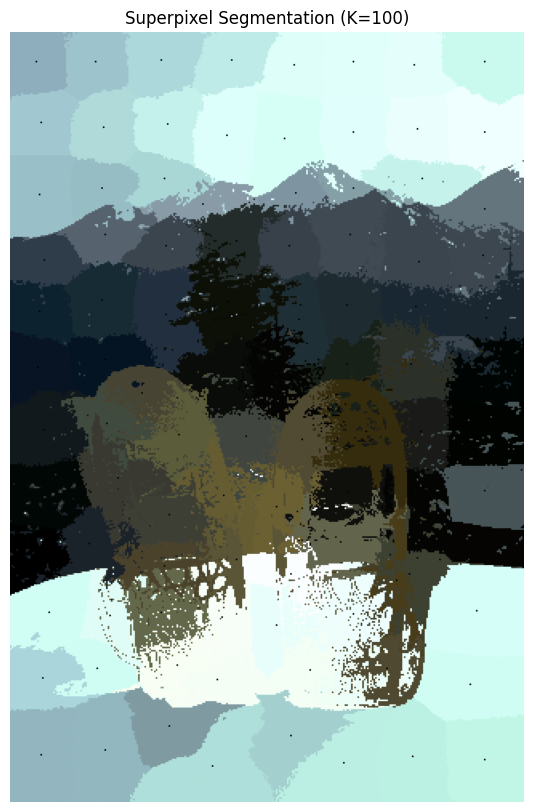

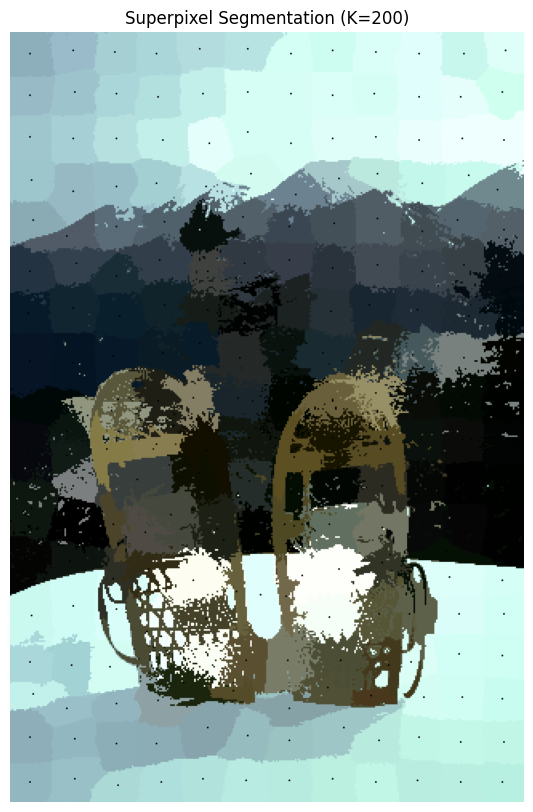

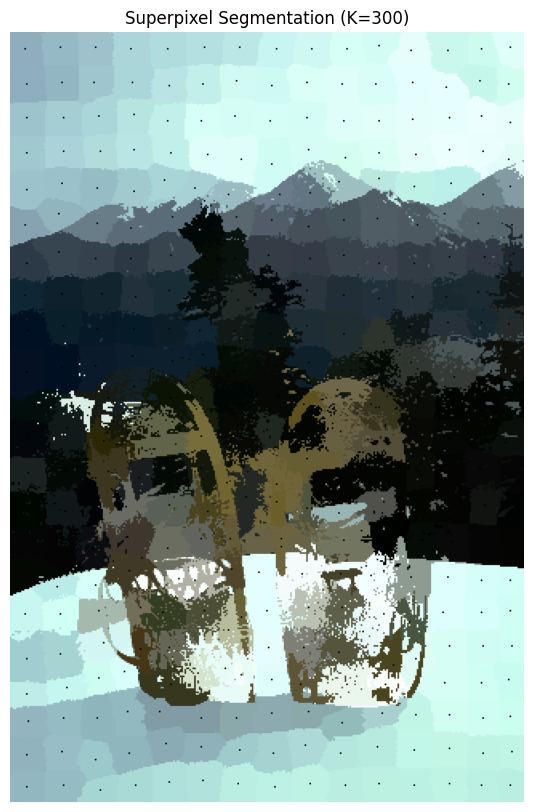

In [9]:
class SuperPixel:
    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = []

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w

def make_SuperPixel(h, w, img):
    return SuperPixel(img[h, w][0], img[h, w][1], img[h, w][2], h, w)

def initialize_cluster_centers(S, image, img_h, img_w):
    clusters = []
    for h in range(int(S/2), img_h, S):
        for w in range(int(S/2), img_w, S):
            clusters.append(make_SuperPixel(h, w, image))
    return clusters

def get_gradient(h, w, image):
    if w + 1 >= image.shape[1]:
        w = image.shape[1] - 2
    if h + 1 >= image.shape[0]:
        h = image.shape[0] - 2
    gradientx = np.sqrt((image[h][w+1][0] - image[h][w-1][0])**2 + (image[h][w+1][1] - image[h][w-1][1])**2 + (image[h][w+1][2] - image[h][w-1][2])**2)
    gradienty = np.sqrt((image[h+1][w][0] - image[h-1][w][0])**2 + (image[h+1][w][1] - image[h-1][w][1])**2 + (image[h+1][w][2] - image[h-1][w][2])**2)
    gradient = gradientx + gradienty
    return gradient

def relocate_cluster_center_at_lowgrad(clusters, image):
    for c in clusters:
        gradient = get_gradient(c.h, c.w, image)
        for h in range(-1, 2):
            for w in range(-1, 2):
                x = c.h + h
                y = c.w + w
                new_gradient = get_gradient(x, y, image)
                if new_gradient < gradient:
                    c.update(image[x][y][0], image[x][y][1], image[x][y][2], x, y)
                    gradient = new_gradient

def assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis, M):
    for c in clusters:
        for h in range(int(c.h - 2 * S), int(c.h + 2 * S)):
            if h < 0 or h >= img_h:
                continue
            for w in range(int(c.w - 2 * S), int(c.w + 2 * S)):
                if w < 0 or w >= img_w:
                    continue
                l, a, b = image[h, w]
                Dc = np.sqrt((l - c.l)**2 + (a - c.a)**2 + (b - c.b)**2)
                Ds = np.sqrt((h - c.h)**2 + (w - c.w)**2)
                D = np.sqrt((Dc / M)**2 + (Ds / S)**2)
                if D < dis[h, w]:
                    if (h, w) not in cluster_tag:
                        cluster_tag[(h, w)] = c
                        c.pixels.append((h, w))
                    else:
                        cluster_tag[(h, w)].pixels.remove((h, w))
                        cluster_tag[(h, w)] = c
                        c.pixels.append((h, w))
                    dis[h, w] = D

def update_clusters(clusters, image):
    for c in clusters:
        sum_h, sum_w = 0, 0
        for pixel in c.pixels:
            sum_h += pixel[0]
            sum_w += pixel[1]
        mean_h = sum_h // len(c.pixels)
        mean_w = sum_w // len(c.pixels)
        c.update(image[mean_h, mean_w][0], image[mean_h, mean_w][1], image[mean_h, mean_w][2], mean_h, mean_w)

def compute_res_error(old_clusters, new_clusters):
    error = 0.0
    for new_c, old_c in zip(new_clusters, old_clusters):
        error_lab = np.abs(new_c.l - old_c.l) + np.abs(new_c.a - old_c.a) + np.abs(new_c.b - old_c.b)
        error_hw = np.abs(new_c.h - old_c.h) + np.abs(new_c.w - old_c.w)
        error += error_lab + error_hw
    return error

def slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis, M, num_iterations=10, error_threshold=0.1):
    clusters = initialize_cluster_centers(S, image, img_h, img_w)
    relocate_cluster_center_at_lowgrad(clusters, image)
    
    for _ in range(num_iterations):
        old_clusters = copy.deepcopy(clusters)
        assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis, M)
        update_clusters(clusters, image)
        error = compute_res_error(old_clusters, clusters)
        if error < error_threshold:
            break

    return clusters

def extract_superpixel_edges(segmentation_labels):
    edges = segmentation.find_boundaries(segmentation_labels)
    return edges.astype(np.uint8)

def compute_boundary_recall(ground_truth_edges, superpixel_edges, tolerance=3):
    true_positives = 0
    total_ground_truth_edges = np.sum(ground_truth_edges)
    
    for y in range(ground_truth_edges.shape[0]):
        for x in range(ground_truth_edges.shape[1]):
            if ground_truth_edges[y, x] == 1:
                # Check within the tolerance distance
                for dy in range(-tolerance, tolerance + 1):
                    for dx in range(-tolerance, tolerance + 1):
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < ground_truth_edges.shape[0] and 0 <= nx < ground_truth_edges.shape[1]:
                            if superpixel_edges[ny, nx] == 1:
                                true_positives += 1
                                break
                    else:
                        continue
                    break
    
    recall = true_positives / total_ground_truth_edges
    return recall

def compute_under_segmentation(ground_truth, superpixels):
    N = ground_truth.size  # Total number of pixels in the image
    under_segmentation_error = 0

    # Get the unique segments and superpixels
    unique_segments = np.unique(ground_truth)
    unique_superpixels = np.unique(superpixels)

    for S in unique_segments:
        mask_S = (ground_truth == S)
        for P in unique_superpixels:
            mask_P = (superpixels == P)
            intersection = np.sum(mask_S & mask_P)
            if intersection > 0:
                under_segmentation_error += min(intersection, np.sum(mask_P) - intersection)

    U = under_segmentation_error / N
    return U

def display_image(img, title=''):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def display_clusters(image, clusters, title):
    img = np.copy(image)
    for c in clusters:
        for p in c.pixels:
            img[p[0], p[1]][0] = c.l
            img[p[0], p[1]][1] = c.a
            img[p[0], p[1]][2] = c.b
        img[c.h, c.w][0] = 0
        img[c.h, c.w][1] = 0
        img[c.h, c.w][2] = 0
    rgb_arr = color.lab2rgb(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_arr)
    plt.title(title)
    plt.axis('off')
    plt.show()

def run_slic(image_path, K_values, ground_truth_segmentations, ground_truth_edges_list):
    image = img_as_float(io.imread(image_path))
    image_lab = color.rgb2lab(image)
    img_h, img_w = image.shape[:2]
    
    boundary_recall_list = []
    under_segmentation_list = []
    running_time_list = []
    
    for K in K_values:
        N = img_h * img_w
        S = int(math.sqrt(N / K))
        
        clusters = []
        cluster_tag = {}
        dis = np.full((img_h, img_w), np.inf)
        
        start_time = timeit.default_timer()
        clusters = slic_algorithm(S, image_lab, img_h, img_w, clusters, cluster_tag, dis, M=15)
        end_time = timeit.default_timer()
        
        elapsed_time = end_time - start_time
        running_time_list.append(elapsed_time)
        
        # Convert the clusters to a label image
        segmentation_labels = np.zeros((img_h, img_w), dtype=np.int32)
        for label, cluster in enumerate(clusters):
            for (h, w) in cluster.pixels:
                segmentation_labels[h, w] = label
        
        # Compute Boundary Recall
        superpixel_edges = extract_superpixel_edges(segmentation_labels)
        ground_truth_edges = ground_truth_edges_list[image_path]
        boundary_recalls = [compute_boundary_recall(ground_truth_edge, superpixel_edges) for ground_truth_edge in ground_truth_edges]
        average_boundary_recall = np.mean(boundary_recalls)
        boundary_recall_list.append(average_boundary_recall)
        
        # Compute Under-segmentation measure
        ground_truth = ground_truth_segmentations[image_path]
        under_segmentations = [compute_under_segmentation(ground_truth_segment, segmentation_labels) for ground_truth_segment in ground_truth]
        average_under_segmentation = np.mean(under_segmentations)
        under_segmentation_list.append(average_under_segmentation)
        
        # Display the superpixel segmentation
        display_clusters(image_lab, clusters, f'Superpixel Segmentation (K={K})')
    
    return boundary_recall_list, under_segmentation_list, running_time_list

# Define K values
K_values = [16, 64, 256, 1024]

# Load BSDS500 dataset ground truth segmentations and edges
ground_truth_segmentations = {}  # Load ground truth segmentations
ground_truth_edges_list = {}     # Load ground truth edges

# Set image paths
image_paths = [
    "Q1/BSDS/2018.jpg",
    "Q1/BSDS/3063.jpg",
    "Q1/BSDS/5096.jpg",
    "Q1/BSDS/6046.jpg"
]

# Load ground truth segmentations and edges
for image_path in image_paths:
    base_name = os.path.splitext(image_path)[0]
    ground_truth_segmentations[image_path] = [io.imread(f"{base_name}_e{i}.bmp", as_gray=True) for i in range(1, 6)]
    ground_truth_edges_list[image_path] = [io.imread(f"{base_name}_s{i}.tif", as_gray=True) for i in range(1, 6)]
    
# Run SLIC algorithm and evaluate metrics
for image_path in image_paths:
    boundary_recall_list, under_segmentation_list, running_time_list = run_slic(image_path, K_values, ground_truth_segmentations, ground_truth_edges_list)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(K_values, boundary_recall_list, marker='o')
    plt.title(f'Boundary Recall for {os.path.basename(image_path)}')
    plt.xlabel('K')
    plt.ylabel('Boundary Recall')
    
    plt.subplot(1, 3, 2)
    plt.plot(K_values, under_segmentation_list, marker='o')
    plt.title(f'Under-segmentation for {os.path.basename(image_path)}')
    plt.xlabel('K')
    plt.ylabel('Under-segmentation')
    
    plt.subplot(1, 3, 3)
    plt.plot(K_values, running_time_list, marker='o')
    plt.title(f'Running Time for {os.path.basename(image_path)}')
    plt.xlabel('K')
    plt.ylabel('Running Time (seconds)')
    
    plt.tight_layout()
    plt.show()